$\newcommand{\Reals}{\mathbb{R}}
\newcommand{\Nats}{\mathbb{N}}
\newcommand{\PDK}{{k}}
\newcommand{\IS}{\mathcal{X}} 
\newcommand{\FM}{\Phi} 
\newcommand{\Gram}{G} 
\newcommand{\RKHS}{\mathcal{H}}
\newcommand{\prodDot}[2]{\left\langle#1,#2\right\rangle}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}$

<center>
 <h1>Tutorial on modern kernel methods</h1>
    <br/>
    <br/>
    <br/>
 Ingmar Schuster<br/><br/>
    <i>(Zalando Research)</i>
</center>

## Overview
- Introduction
- Feature engineering and two simple classification algorithms
- Kernels and feature space
- Applications
    - mean embedding, conditional mean embedding and operators
    - Training GANs
    - Regression with uncertainty estimates
- Conclusion and outlook


# Introduction

## Kernel methods
- Support Vector Machines (SVMs) are a staple for classification
- Gaussian Processes (GPs) very popular for regression
- kernel mean embedding of distributions/conditional distributions
- recent techniques for representation learning/unsupervised learning 
    * Deep Gaussian Processes
    * Compositional Kernel Machines
- very elegant mathematics

In [14]:
### FIRST SOME CODE ####

from __future__ import division, print_function, absolute_import
from IPython.display import SVG, display, Image, HTML

import numpy as np, scipy as sp, pylab as pl, matplotlib.pyplot as plt, scipy.stats as stats, sklearn, sklearn.datasets
from scipy.spatial.distance import squareform, pdist, cdist

import rkhs_operators as ro

import distributions as dist #commit 480cf98 of https://github.com/ingmarschuster/distributions

pl.style.use(u'seaborn-talk')

## Gaussian Processes
- model for functions/continuous output
- for new input returns predicted output and uncertainty

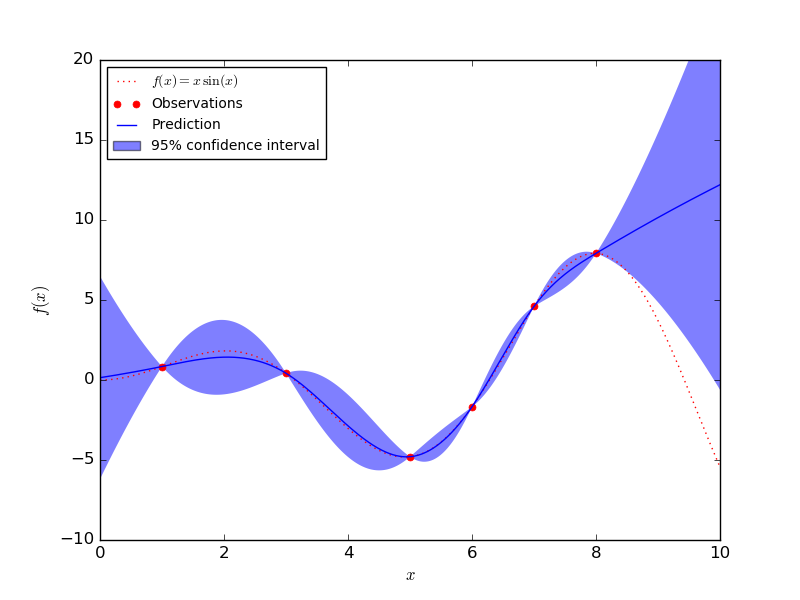

In [15]:
display(Image(filename="GP_uq.png", width=630)) #source: http://scikit-learn.org/0.17/modules/gaussian_process.html

## Support Vector Machines
- model for classification
- map data nonlinearly to higher dimensionsal space
- separate points of different classes using a plane (i.e. linearly)

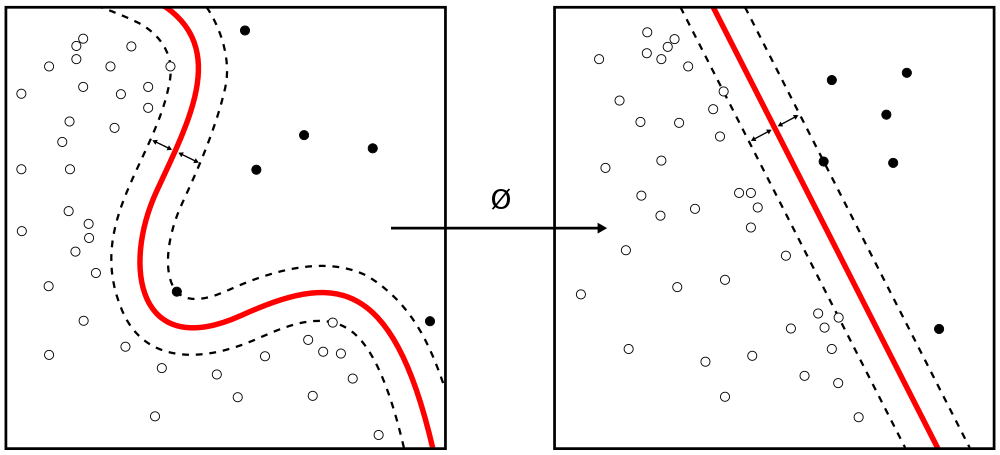

In [16]:
display(Image(filename="SVM.png", width=700)) #source: https://en.wikipedia.org/wiki/Support_vector_machine

# Feature engineering and two classification algorithms

# Feature engineering in Machine Learning

* feature engineering: map data to *features* with function $\FM:\IS\to \RKHS$
    - handle nonlinear relations with linear methods ($\FM$ nonlinear)
    - handle non-numerical data (e.g. text)

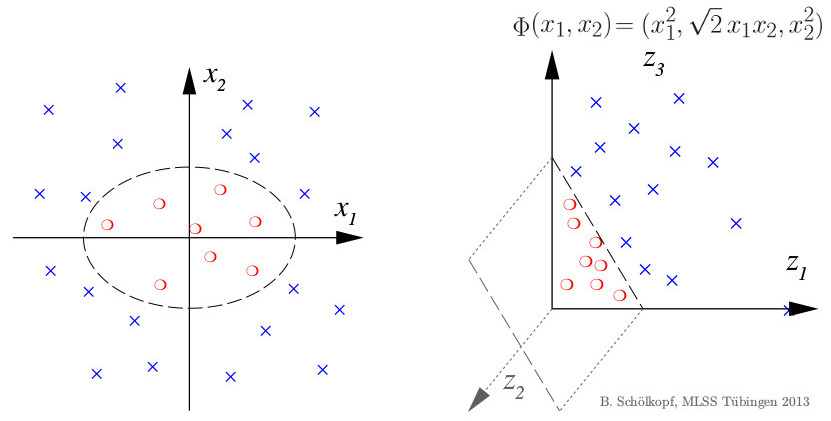

In [17]:
display(Image(filename="monomials_small.jpg", width=800)) #source: Berhard Schölkopf

### Working in Feature Space
- want Feature Space $\RKHS$ (the codomain of $\FM$) to be vector space to get nice mathematical structure
- definition of inner products induces norms and possibility to measure angles
- can use linear algebra in $\RKHS$ to solve ML problems
    - inner products
    - angles
    - norms
    - distances
- induces nonlinear operations on the Input Space (domain of $\FM$)

### Two simple classification algorithms
- given data points from mixture of two distributions with densities $p_0,p_1$:
$$x_i \sim 0.5 p_0 + 0.5 p_1$$
    and label $l_i = 0$ if $x_i$  generated by $p_0$, $l_i = 1$ otherwise

In [18]:
figkw = {"figsize":(4,4), "dpi":150}
np.random.seed(5)
samps_per_distr = 20
data = np.vstack([stats.multivariate_normal(np.array([-2,0]), np.eye(2)*1.5).rvs(samps_per_distr),
                  stats.multivariate_normal(np.array([2,0]), np.eye(2)*1.5).rvs(samps_per_distr)])
distr_idx = np.r_[[0]*samps_per_distr, [1]*samps_per_distr]

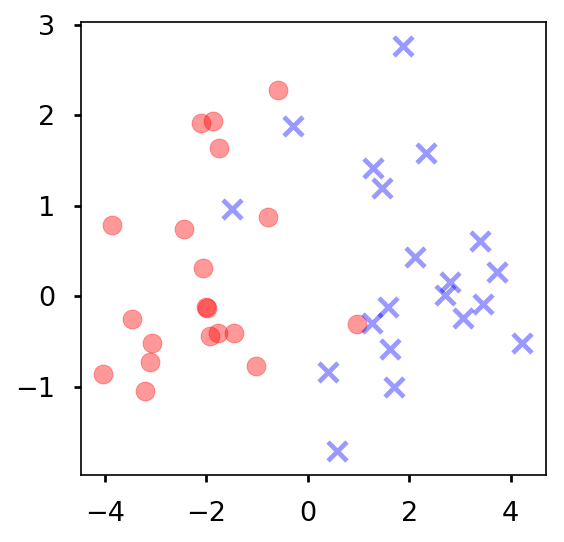

In [19]:
f = pl.figure(**figkw);
for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
    plt.scatter(*data[distr_idx==idx,:].T, c=c, marker=marker, alpha = 0.4)
pl.show()

### Classification using inner products in Feature Space
- compute mean feature space embedding $$\mu_{0} = \frac{1}{N_0} \sum_{l_i = 0} \FM(x_i) ~~~~~~~~ \mu_{1} = \frac{1}{N_1} \sum_{l_i = 1} \FM(x_i)$$
- assign test point to most similar class in terms of inner product between point and mean embedding $\prodDot{\FM(x)}{\mu_c}$
$$f_d(x) = \argmax_{c\in\{0,~1\}} \prodDot{\FM(x)}{\mu_c}$$
    (remember in $\Reals^2$ canonically: $\prodDot{a}{b} = a_1 b_1+a_2 b_2 $)
    

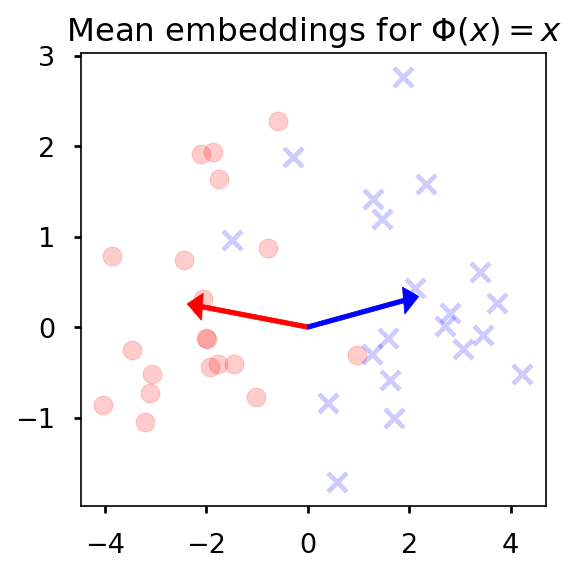

In [20]:
pl.figure(**figkw)
for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
    pl.scatter(*data[distr_idx==idx,:].T, c=c, marker=marker, alpha=0.2)
    pl.arrow(0, 0, *data[distr_idx==idx,:].mean(0), head_width=0.3, width=0.05, head_length=0.3, fc=c, ec=c)
pl.title(r"Mean embeddings for $\Phi(x)=x$");

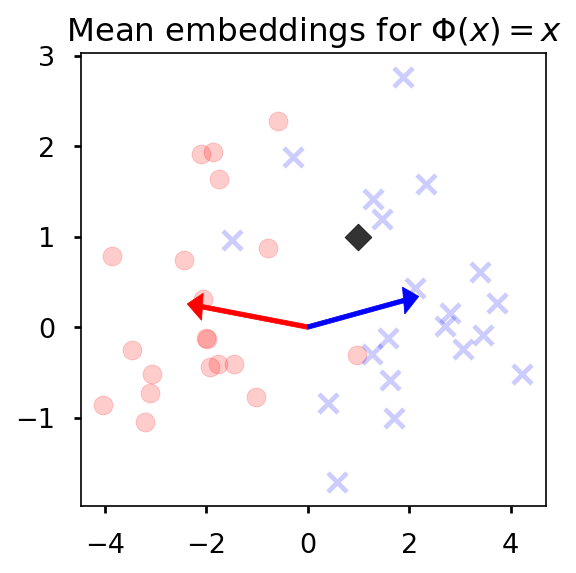

In [21]:
pl.figure(**figkw)
for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
    pl.scatter(*data[distr_idx==idx,:].T, c=c, marker=marker, alpha=0.2)
    pl.arrow(0, 0, *data[distr_idx==idx,:].mean(0), head_width=0.3, width=0.05, head_length=0.3, fc=c, ec=c)
pl.title(r"Mean embeddings for $\Phi(x)=x$");
pl.scatter(np.ones(1), np.ones(1), c='k', marker='D', alpha=0.8);

### Classification using density estimation
- estimate density for each class by centering a gaussian, taking mixture as estimate
    $$\widehat{p}_0 = \frac{1}{N_0} \sum_{l_i = 0} \mathcal{N}(\cdot; x_i,\Sigma) ~~~~~~~~ \widehat{p}_1 = \frac{1}{N_1} \sum_{l_i = 1} \mathcal{N}(\cdot; x_i,\Sigma)$$


In [22]:
# Some plotting code

def apply_to_mg(func, *mg):
    #apply a function to points on a meshgrid
    x = np.vstack([e.flat for e in mg]).T
    return np.array([func(i.reshape((1,2))) for i in x]).reshape(mg[0].shape)

def plot_with_contour(samps, data_idx, cont_func, method_name = None, delta = 0.025, pl = pl, colormesh_cmap = pl.cm.Pastel2, contour_classif = True):
    x = np.arange(samps.T[0].min()-delta, samps.T[1].max()+delta, delta)
    y = np.arange(samps.T[1].min()-delta, samps.T[1].max()+delta, delta)
    X, Y = np.meshgrid(x, y)
    Z = apply_to_mg(cont_func, X,Y)
    Z = Z.reshape(X.shape)
    

    fig = pl.figure(**figkw)
    if colormesh_cmap is not None:
        bound = np.abs(Z).max()
        pl.pcolor(X, Y, Z , cmap=colormesh_cmap, alpha=0.5, edgecolors=None, vmin=-bound, vmax=bound)
    if contour_classif is True:
        c = pl.contour(X, Y, Z, colors=['k', ],
                       alpha = 0.5,
                       linestyles=[ '--'],
                       levels=[0],
                       linewidths=0.7)
    else:
        pl.contour(X, Y, Z, linewidths=0.7)
    if method_name is not None:
        pl.title(method_name)
    for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
        pl.scatter(*data[distr_idx==idx,:].T, c=c, marker=marker, alpha = 0.4)

    pl.show()
    pl.close()

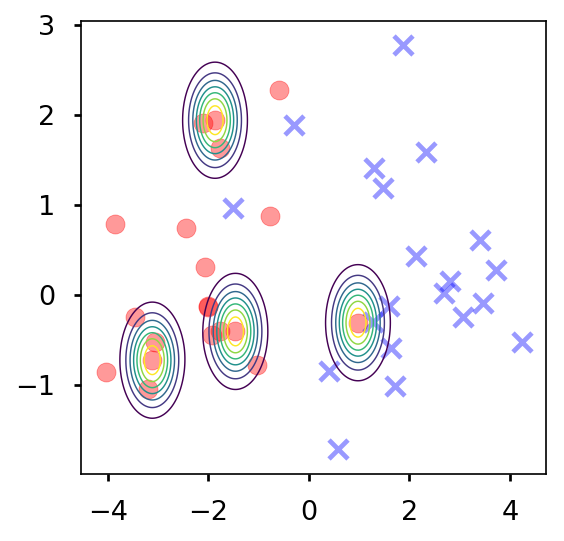

In [23]:
est_dens_1 = dist.mixt(2, [dist.mvnorm(x, np.eye(2)*0.1) for x in data[:4]], [1./4]*4)
plot_with_contour(data, distr_idx,
                  lambda x: exp(est_dens_1.logpdf(x)),
                  colormesh_cmap=None, contour_classif=False)

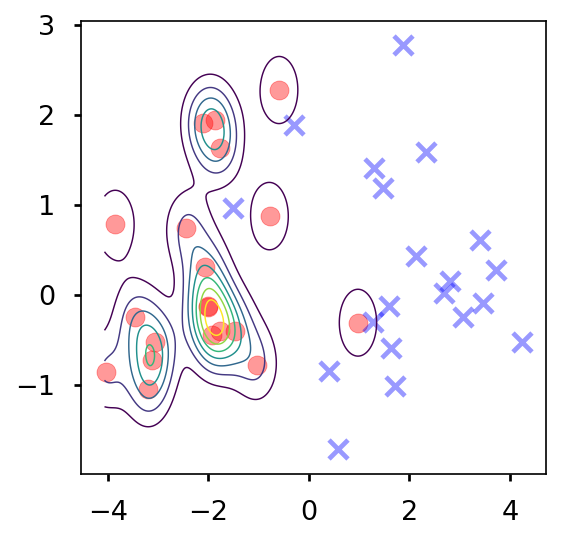

In [24]:
est_dens_1 = dist.mixt(2, [dist.mvnorm(x, np.eye(2)*0.1,10) for x in data[:samps_per_distr]], [1./samps_per_distr]*samps_per_distr)
plot_with_contour(data, distr_idx,
                  lambda x: exp(est_dens_1.logpdf(x)),
                  colormesh_cmap=None, contour_classif=False)

### Classification using density estimation
- estimate density for each class by centering a gaussian, taking mixture as estimate
    $$\widehat{p}_0 = \frac{1}{N_0} \sum_{l_i = 0} \mathcal{N}(\cdot; x_i,\Sigma) ~~~~~~~~ \widehat{p}_1 = \frac{1}{N_1} \sum_{l_i = 1} \mathcal{N}(\cdot; x_i,\Sigma)$$
- assign test point $x$ to class $c$ that gives highest value for $\widehat{p}_c(x)$
- $\widehat{p}_c$ is known as a **kernel density estimate** (KDE)
- different but overlapping notion of 'kernel'
- classification algorithm known as **Parzen windows classification**

<center><h3> For a certain feature map and inner product, both algorithms are the same!</h3></center>


<center>Let's construct this feature map and inner product.</center>

# Kernels and feature space

## Positive definite functions and feature spaces

- let $\PDK:\IS\times\IS \to \Reals$, called a *kernel*
    * if $\PDK$ is a symmetric and *positive semi definite (psd)* 
    * then there exists $\FM: \IS \to \RKHS$ to a hilbert space $\RKHS$ such that $$\PDK(x_i, x_j) = \prodDot{\FM(x_i)}{\FM(x_j)}_\RKHS$$
    i.e. $\PDK$ computes inner product *after mapping* to some $\RKHS$

## Gram matrix (1)
- If all matrices
$$\Gram_{X}=\begin{bmatrix}
\PDK(x_1, x_1) &  \dots & \PDK(x_1, x_N)\\
\PDK(x_2, x_1) & \ddots & \vdots\\
\vdots &  & \vdots\\
\PDK(x_N, x_1) & \dots &  \PDK(x_N, x_N)
\end{bmatrix}$$
are symmetric positive semidefinite, then $\PDK$ is a psd kernel
- called a *gram matrix*

## Gram matrix (2)
- sometimes mixed gram matrices are needed
$$\Gram_{XY} = \begin{bmatrix}
\PDK(x_1, y_1) & \PDK(x_1, y_2) & \dots & \PDK(x_1, y_M)\\
\PDK(x_2, y_1) & \ddots & &\vdots\\
\vdots &  & &\vdots\\
\PDK(x_N, y_1) & \dots &  &\PDK(x_N, y_M)
\end{bmatrix} 
$$

## Examples of psd kernels
- Linear  $\PDK_L(x,x') = \prodDot{x}{x'} = x_1 x'_1 + x_2 x'_2+ \dots$
- Gaussian $\PDK_G(x,x') = \exp({-{ 0.5}(x-x' )^{\top }\Sigma ^{-1}(x-x' )})$

## PSD kernels
- easy to construct $\PDK$ given $\FM$: $\PDK(x_i, x_j) = \prodDot{\FM(x_i)}{\FM(x_j)}$
- construction for $\FM$ given $\PDK$ not trivial but still elementary
- given $\FM$ and inner product in feature space we
    * can endow space with  norm induced by the inner product
$$\|g\|_\RKHS = \sqrt{\prodDot{g}{g}}_\RKHS~~~\textrm{for}~g \in \RKHS$$
    * can measure angles in the new space $$\prodDot{g}{f}_\RKHS = \cos(\angle[g,f])~\|g\|_\RKHS ~\|f\|_\RKHS$$




### Construction of the canonical feature map (Aronszajn map)

Plan
- construction of $\FM$ from $\PDK$
- definition of inner product in new space $\RKHS$ such that in fact $\PDK(x,x') = \prodDot{\FM(x)}{\FM(x)}$
- feature for each $x \in \IS$ will be a function from $\IS$ to $\Reals$
$$\FM:\IS \to \Reals^\IS$$

### Canonical feature map (Aronszajn map)
- pick $\FM(x) = \PDK(\cdot, x)$
    - Linear kernel: $\FM_L(x) = \prodDot{\cdot}{x}$
    - Gaussian kernel: $\FM_G(x) = \exp\left(-0.5{\|\cdot -x \|^2}/{\sigma^2}\right)$.

- let linear combinations of features also be in $\RKHS$
     $$f(\cdot)=\sum_{i=1}^m a_i \PDK(\cdot, x_i) \in \RKHS$$
   for $a_i \in \Reals$
- $\RKHS$ a vector space over $\Reals$ : if $f(\cdot)$ and $g(\cdot)$ functions from $\IS$ to $\Reals$, so are $a~f(\cdot)$ for $a \in \Reals, f(\cdot)+g(\cdot)$

### Canonical inner product (1)
- for $f(\cdot)=\sum_{i=1}^m a_i \PDK(\cdot, x_i) \in \RKHS$ and $g(\cdot)=\sum_{j=1}^{m'} b_j \PDK(\cdot, x'_j) \in \RKHS$ define inner product 
$$\prodDot{f}{g} = \sum_{i=1}^m \sum_{j=1}^{m'} b_j a_i \PDK(x'_j, x_i)$$
- In particular $\prodDot{ \PDK(\cdot,x)}{ \PDK(\cdot,x')}=\PDK(x,x')$ (*reproducing property* of kernel in its $\RKHS$)

### Canonical inner product (2)
- $\RKHS$ a hilbert space with this inner product, as it is
    * positive definite
    * linear in its first argument
    * symmetric
    * complete
- $\RKHS$ called *Reproducing Kernel Hilbert Space (RKHS)*.

### Equivalence of classification algorithms
- Recall mean canonical feature and kernel density estimate
 $$\widehat{p}_0 = \frac{1}{N_0} \sum_{l_i = 0} \mathcal{N}(\cdot; x_i,\Sigma) ~~~~~~~~ \mu_{0} = \frac{1}{N_0} \sum_{l_i = 0} \PDK(\cdot, x_i)$$
- observe
$$\frac{1}{N_0} \sum_{l_i = 0} \mathcal{N}(x^*; x_i,\Sigma) = \prodDot{\frac{1}{N_0} \sum_{l_i = 0} \PDK(\cdot, x_i)}{\PDK(\cdot, x^*)}$$
if $\PDK$ is Gaussian density with covariance $\Sigma$
- kernel mean and Parzen windows classification are equivalent!

   
**Lets look at example classification output**


In [25]:
class KMEclassification(object):
    def __init__(self, samps1, samps2, kernel):
        self.de1 = ro.RKHSDensityEstimator(samps1, kernel, 0.1)
        self.de2 = ro.RKHSDensityEstimator(samps2, kernel, 0.1)
    
    def classification_score(self, test):
        return (self.de1.eval_kme(test) - self.de2.eval_kme(test))

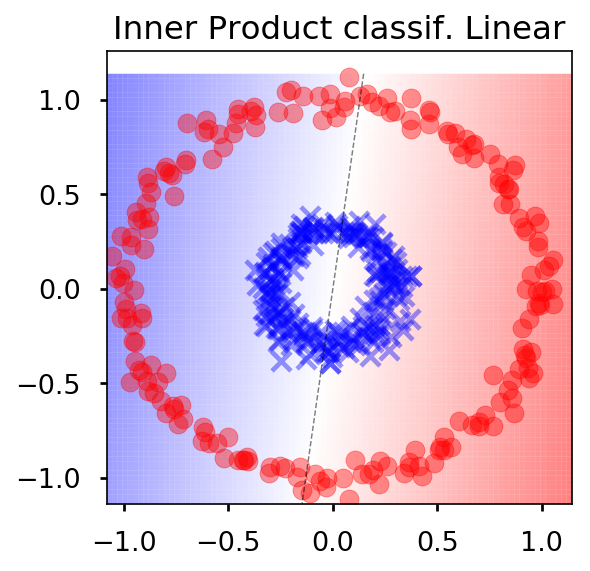

In [26]:
data, distr_idx = sklearn.datasets.make_circles(n_samples=400, factor=.3, noise=.05)

kc = KMEclassification(data[distr_idx==0,:], data[distr_idx==1,:],  ro.LinearKernel())
plot_with_contour(data, distr_idx, kc.classification_score, 'Inner Product classif. '+"Linear", pl = plt, contour_classif = True, colormesh_cmap = pl.cm.bwr)

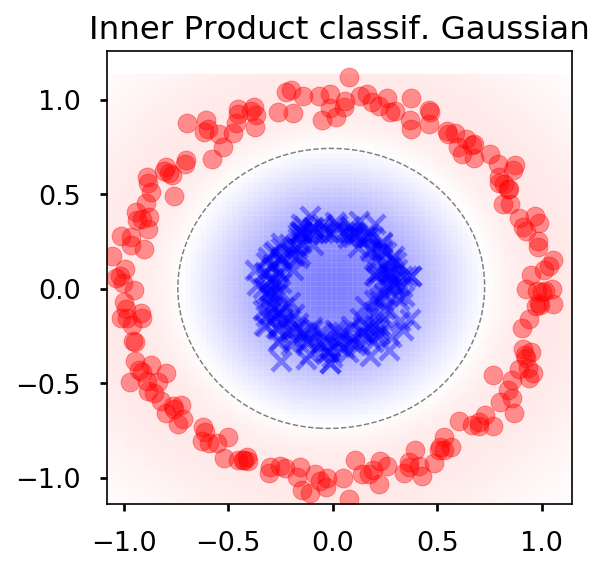

In [27]:
kc = KMEclassification(data[distr_idx==0,:], data[distr_idx==1,:],  ro.GaussianKernel(0.3))
plot_with_contour(data, distr_idx, kc.classification_score, 'Inner Product classif. '+"Gaussian", pl = plt, contour_classif = True, colormesh_cmap = pl.cm.bwr)

# Applications

## Kernel mean embedding
- mean feature with canonical feature map $\frac{1}{N} \sum_{i = 1}^N \FM(x_i)  = \frac{1}{N} \sum_{i = 1}^N \PDK(x_i, \cdot)$
- this the estimate of the *kernel mean embedding*  of the distribution/density $\rho$ of $x_i$
    $$\mu_\rho(\cdot) = \int \PDK(x,\cdot) \mathrm{d}\rho(x)$$
- using this we can define a distance between distributions $\rho, q$ as
$$\mathrm{MMD}(\rho, q)^2 = \|\mu_\rho - \mu_q \|^2_\RKHS$$
called the maximum mean discrepancy (*MMD*)
- Has been used as the critic in generative adversial networks (i.e. generative network as usual, MMD as drop-in for discriminator)

## Conditional mean embedding (1)
- we can define operators on RKHSs
- these are maps from RKHS elements to RKHS elements (i.e. mapping between functionals)
- one such operator is the *conditional mean embedding* $\mathcal{D}_{Y|X}$
    * given the embedding of the input variables distribution, returns the embedding of the output variables distribution
- Regression with uncertainty estimate 


## Conditional mean embedding (2)
An example

In [28]:
out_samps = data[distr_idx==0,:1] + 1
inp_samps = data[distr_idx==0,1:] + 1
def plot_mean_embedding(cme, inp_samps, out_samps, p1 = 0., p2 = 1., offset = 0.5):
    x = np.linspace(inp_samps.min()-offset,inp_samps.max()+offset,200)
    fig = pl.figure(figsize=(10, 5))
    ax = [pl.subplot2grid((2, 2), (0, 1)),
          pl.subplot2grid((2, 2), (0, 0), rowspan=2),
          pl.subplot2grid((2, 2), (1, 1))]

    ax[1].scatter(out_samps, inp_samps, alpha=0.3, color = 'r')
    ax[1].set_xlabel('Output')
    ax[1].set_ylabel('Input')
    ax[1].axhline(p1, 0, 8, color='g', linestyle='--')
    ax[1].axhline(p2, 0, 8, color='b', linestyle='--')
    ax[1].set_title("%d input-output pairs"%len(out_samps))
    ax[1].set_yticks((p1, p2))
    e = cme.lhood(np.array([[p1], [p2]]), x[:, None]).T
    
    #ax[0].plot(x, d[0], '-', label='cond. density')
    ax[2].plot(x, e[0], 'g--', label='cond. mean emb.')
    ax[2].set_title(r"p(outp | inp=%.1f)"%p1)
    ax[0].plot(x, e[1], 'b--', label='cond. mean emb.')
    ax[0].set_title(r"p(outp | inp=%.1f)"%p2)
    #ax[2].legend(loc='best')
    fig.tight_layout()

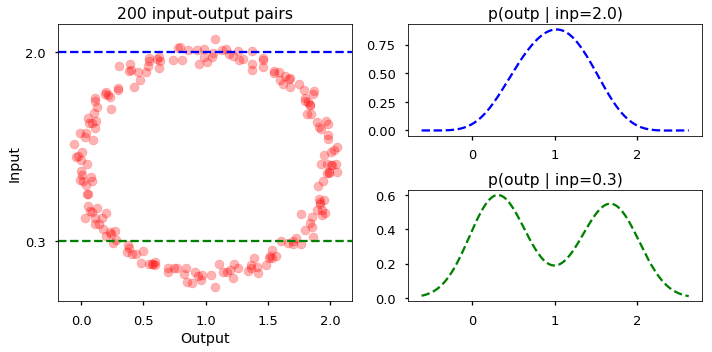

In [29]:
cme = ro.ConditionMeanEmbedding(inp_samps, out_samps, ro.GaussianKernel(0.3), ro.GaussianKernel(0.3), 5)
plot_mean_embedding(cme, inp_samps, out_samps,  0.3, 2.,)

## Conditional mean embedding (3)
- closed form estimate given samples from input and output
$$\begin{bmatrix}\PDK_Y(y_1, \cdot),& \dots &, \PDK_Y(y_N, \cdot)\end{bmatrix} \Gram_X^{-1} \begin{bmatrix}\PDK_X(x_1, \cdot)\\ \vdots \\ \PDK_X(x_N, \cdot)\end{bmatrix}$$
    
- closed form estimate of output embedding for new input $x^*$

$$\prodDot{\mathcal{D}_{Y|X}}{\PDK(x^*,\cdot)} = \begin{bmatrix}\PDK_Y(y_1, \cdot),& \dots &, \PDK_Y(y_N, \cdot)\end{bmatrix} \Gram_X^{-1} \begin{bmatrix}\PDK_X(x_1, x^*)\\ \vdots \\ \PDK_X(x_N, x^*)\end{bmatrix}$$

## Conditional mean embedding (4)
- Similar to Gaussian processes, but output distribution more flexible
    * mixture of Gaussians, Laplace, distributions on discrete objects
    * multimodality can be represented
    * multidimensional output
    * output can be combination of e.g. string and reals
- Conditional mean embedding was used to construct *Kernel Bayes Rule*, enabling closed form Bayesian inference
- other types of operators have been derived (see Stefan Klus' talk next week)

In [30]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/MpzaCCbX-z4?rel=0&amp;showinfo=0&amp;start=148" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

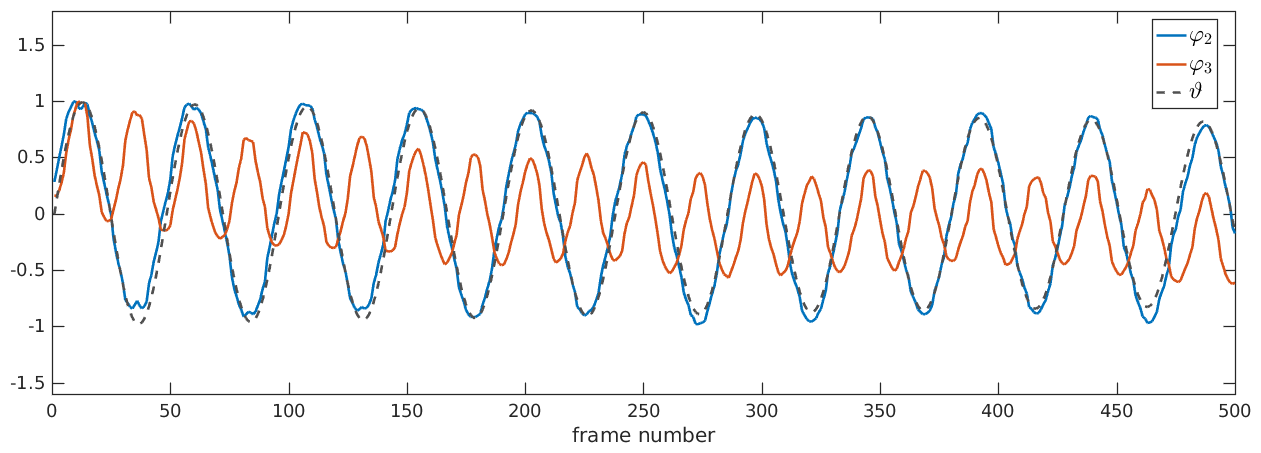

In [31]:
display(Image(filename="Pendulum_eigenfunctions.png", width=700))

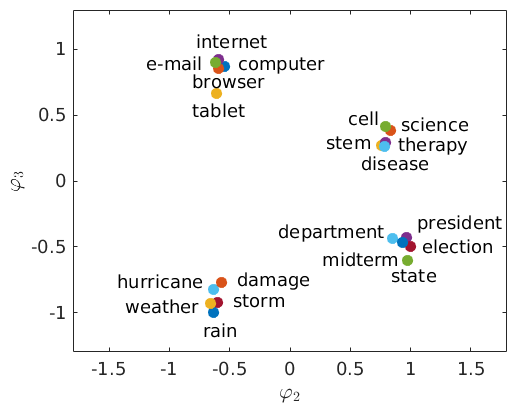

In [32]:
display(Image(filename="KeywordClustering.png", width=700))

# Conclusion and Outlook

## Conclusion and Outlook
- kernels implicitly compute inner products in well-behaved vector spaces
- use angles, norms, distances in these for ML algorithms
- successful models in ML build on PSD kernels
    * kernel induced covariance structure (Gaussian Processes)    
    * kernel embedding of probability distributions 
        - measuring distance between distributions
    * kernel embedding of conditional probability distributions

Get slides at <a href="http://ingmarschuster.com">ingmarschuster.com</a>